## The ML Pipeline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/python code project

/content/drive/MyDrive/python code project


In [3]:
from gru_model import *
from lstm_model import *
from utils import *
from training import *

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

In [5]:
print(torch.__version__)

2.5.1+cu121


## Exploratory Data Analysis (EDA)

In [6]:
# Define data root directory
data_dir = "/content/data"
print(os.listdir(data_dir))

['DAYTON_hourly.csv', 'EKPC_hourly.csv', 'NI_hourly.csv', 'AEP_hourly.csv', 'COMED_hourly.csv', 'PJM_Load_hourly.csv', 'DOM_hourly.csv', 'PJME_hourly.csv', 'DUQ_hourly.csv', 'FE_hourly.csv', 'DEOK_hourly.csv', 'PJMW_hourly.csv']


In [7]:
pd.read_csv(os.path.join(data_dir, "DEOK_hourly.csv")).head()

,Datetime,DEOK_MW
0,2012-12-31 01:00:00,2945.0
1,2012-12-31 02:00:00,2868.0
2,2012-12-31 03:00:00,2812.0
3,2012-12-31 04:00:00,2812.0
4,2012-12-31 05:00:00,2860.0


## Create training instances by moving sliding window

## Integrate files to build the training set
To speed things up, I will only be using `num_files_for_dataset` .csv files for creating my dataset. Feel free to run it yourself with the entire dataset if you have the time and computing capacity.

In [8]:
label_col_index = 0  # consumption as label to predict
inputs_cols_indices = range(
    5
)  # use (consumption, hour, dayofweek, month, dayofyear) columns as features

# Define window_size period and split inputs/labels
window_size = 90

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# Skipping the files we're not using
processing_files = [
    file for file in os.listdir(data_dir) if os.path.splitext(file)[1] == ".csv"
]

num_files_for_dataset = 5

for file in tqdm_notebook(processing_files[:num_files_for_dataset]):
    print(f"Processing {file} ...")
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(os.path.join(data_dir, file), parse_dates=["Datetime"])

    # Processing the time data into suitable input formats
    df["hour"] = df.apply(lambda x: x["Datetime"].hour, axis=1)
    df["dayofweek"] = df.apply(lambda x: x["Datetime"].dayofweek, axis=1)
    df["month"] = df.apply(lambda x: x["Datetime"].month, axis=1)
    df["dayofyear"] = df.apply(lambda x: x["Datetime"].dayofyear, axis=1)
    df = df.sort_values("Datetime").drop("Datetime", axis=1)

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)

    # Obtaining the scaler for the labels(usage data) so that output can be
    # re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
    label_scalers[file] = label_sc

    # Move the window
    inputs, labels = move_sliding_window(
        data,
        window_size,
        inputs_cols_indices=inputs_cols_indices,
        label_col_index=label_col_index,
    )

    # CONCAT created instances from all .csv files.
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1 * len(inputs))
    if len(train_x) == 0:  # first iteration
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x, inputs[:-test_portion]))
        train_y = np.concatenate((train_y, labels[:-test_portion]))
    test_x[file] = inputs[-test_portion:]
    test_y[file] = labels[-test_portion:]

  0%|          | 0/5 [00:00<?, ?it/s]

Processing DAYTON_hourly.csv ...
(121185, 90, 5) (121185, 1)
Processing EKPC_hourly.csv ...
(45244, 90, 5) (45244, 1)
Processing NI_hourly.csv ...
(58360, 90, 5) (58360, 1)
Processing AEP_hourly.csv ...
(121183, 90, 5) (121183, 1)
Processing COMED_hourly.csv ...
(66407, 90, 5) (66407, 1)


## What have we made?

In [9]:
test_x.keys()

dict_keys(['DAYTON_hourly.csv', 'EKPC_hourly.csv', 'NI_hourly.csv', 'AEP_hourly.csv', 'COMED_hourly.csv'])

In [10]:
train_x.shape, test_x["DAYTON_hourly.csv"].shape

((371143, 90, 5), (12118, 90, 5))

## Pytorch data loaders/generators

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The `TensorDataset` and `DataLoader` classes are useful for splitting our data into batches and shuffling them.

In [11]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)

In [12]:
print(
    f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}"
)

Train Size: (371143, 90, 5), Batch Size: 1024, # of iterations per epoch: 362


In [13]:
# release some memory
del train_x, train_y

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using "https://colab.research.google.com/" with GPU to run this code, the training time will be significantly reduced.

In [14]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")

GPU is available


## Training the GRU model

In [15]:
# seq_len = 90  # (timestamps)
n_hidden = 256
n_layers = 2
n_epochs = 5
print_every = 100
lr = 0.001
gru_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="GRU",
    print_every=print_every,
    device=device,
)

Starting Training of GRU model
Epoch 1 - Step: 100/362 - Average Loss for Epoch: 0.008246924137929455
Epoch 1 - Step: 200/362 - Average Loss for Epoch: 0.004703761132259387
Epoch 1 - Step: 300/362 - Average Loss for Epoch: 0.0033797962858807297
Epoch 1/5 Done, Total Loss: 0.002896504765373233
Time Elapsed for Epoch: 44.58034477999999 seconds
Epoch 2 - Step: 100/362 - Average Loss for Epoch: 0.0004476935201091692
Epoch 2 - Step: 200/362 - Average Loss for Epoch: 0.00040215055720182135
Epoch 2 - Step: 300/362 - Average Loss for Epoch: 0.0003730340839441245
Epoch 2/5 Done, Total Loss: 0.0003551003068202504
Time Elapsed for Epoch: 48.697535359 seconds
Epoch 3 - Step: 100/362 - Average Loss for Epoch: 0.00025614534839405676
Epoch 3 - Step: 200/362 - Average Loss for Epoch: 0.00025011065015860366
Epoch 3 - Step: 300/362 - Average Loss for Epoch: 0.00023931117582833393
Epoch 3/5 Done, Total Loss: 0.0002363634458405367
Time Elapsed for Epoch: 48.66233702400001 seconds
Epoch 4 - Step: 100/362 -

## Save the GRU model

In [17]:
model_path = "/content/models/gru_model.pt"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)  # exist_ok prevents errors if directory exists

# Save the model state dictionary
torch.save(gru_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/models/gru_model.pt


## Train and Save an LSTM model

In [18]:
lstm_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="LSTM",
    print_every=print_every,
    device=device,
)

Starting Training of LSTM model
Epoch 1 - Step: 100/362 - Average Loss for Epoch: 0.01408970039570704
Epoch 1 - Step: 200/362 - Average Loss for Epoch: 0.008051726342528128
Epoch 1 - Step: 300/362 - Average Loss for Epoch: 0.005774302136463423
Epoch 1/5 Done, Total Loss: 0.004931784954818624
Time Elapsed for Epoch: 62.91655278799999 seconds
Epoch 2 - Step: 100/362 - Average Loss for Epoch: 0.0006845836696447805
Epoch 2 - Step: 200/362 - Average Loss for Epoch: 0.0005885641989880242
Epoch 2 - Step: 300/362 - Average Loss for Epoch: 0.0005223620120280733
Epoch 2/5 Done, Total Loss: 0.000491857480850117
Time Elapsed for Epoch: 63.03342304300003 seconds
Epoch 3 - Step: 100/362 - Average Loss for Epoch: 0.00031363214016892014
Epoch 3 - Step: 200/362 - Average Loss for Epoch: 0.00029285230368259363
Epoch 3 - Step: 300/362 - Average Loss for Epoch: 0.00027987012542628995
Epoch 3/5 Done, Total Loss: 0.0002723922080296678
Time Elapsed for Epoch: 63.205593428999975 seconds
Epoch 4 - Step: 100/36

In [19]:
model_path = "/content/models/lstm_model.pt"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)  # exist_ok prevents errors if directory exists

# Save the model state dictionary
torch.save(lstm_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/models/lstm_model.pt


# Evaluating models
#### __Note: Running the following codes needs at least 16GB of memory.__
Moving on to measuring the accuracy of both models, we'll now use our `evaluate()` function and test dataset.

## Load the GRU model

In [16]:
# move device to cpu for evaluation to avoid GPU memory run
# device = "cpu"

In [20]:
device="cpu"

In [21]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers,device=device)
gru_model.load_state_dict(torch.load("/content/models/gru_model.pt"))

<ipython-input-21-d5263246f9a9>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gru_model.load_state_dict(torch.load("/content/models/gru_model.pt"))


<All keys matched successfully>

In [22]:
# Move the model to the appropriate device
gru_model.to(device)

GRUNet(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Load the LSTM model

In [23]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers,device=device)
lstm_model.load_state_dict(torch.load("/content/models/lstm_model.pt"))

<ipython-input-23-51e0bfeb7aca>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load("/content/models/lstm_model.pt"))


<All keys matched successfully>

In [24]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Model Evaluation

For the purpose of comparing the performance of both models as well, we'll being tracking the time it takes for the model to train and eventually comparing the final accuracy of both models on the test set. For our accuracy measure, we'll use ***Symmetric Mean Absolute Percentage Error (sMAPE)*** to evaluate the models. *sMAPE* is the sum of the **absolute difference** between the predicted and actual values divided by the average of the predicted and actual value, therefore giving a percentage measuring the amount of error.

This is the formula for *sMAPE*:

$sMAPE = \frac{100%}{n} \sum_{t=1}^n \frac{|F_t - A_t|}{(|F_t + A_t|)/2}$

## Evaluate performance of GRU

In [25]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers,device=device)

Evaluation Time: 90.07818838799994
sMAPE: 0.292%


## Evaluate performance of LSTM

In [26]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers,device=device)

Evaluation Time: 89.34431379500006
sMAPE: 0.273%


While the GRU model may have made smaller errors and edged the LSTM model slightly in terms of performance accuracy, the difference is insignificant and thus inconclusive. There have been many other tests conducted by others comparing both these models but there has largely been no clear winner as to which is the better architecture overall.

In [27]:
len(
    gru_outputs
)  # list of predicted output file for each state (each element has a 1d array for that state)

5

# Some visualizations

Lastly, let's do some visualizations on random sets of our predicted output vs the actual consumption data for some states.

In [28]:
states_list = list(test_x.keys())

In [29]:
states_list

['DAYTON_hourly.csv',
 'EKPC_hourly.csv',
 'NI_hourly.csv',
 'AEP_hourly.csv',
 'COMED_hourly.csv']

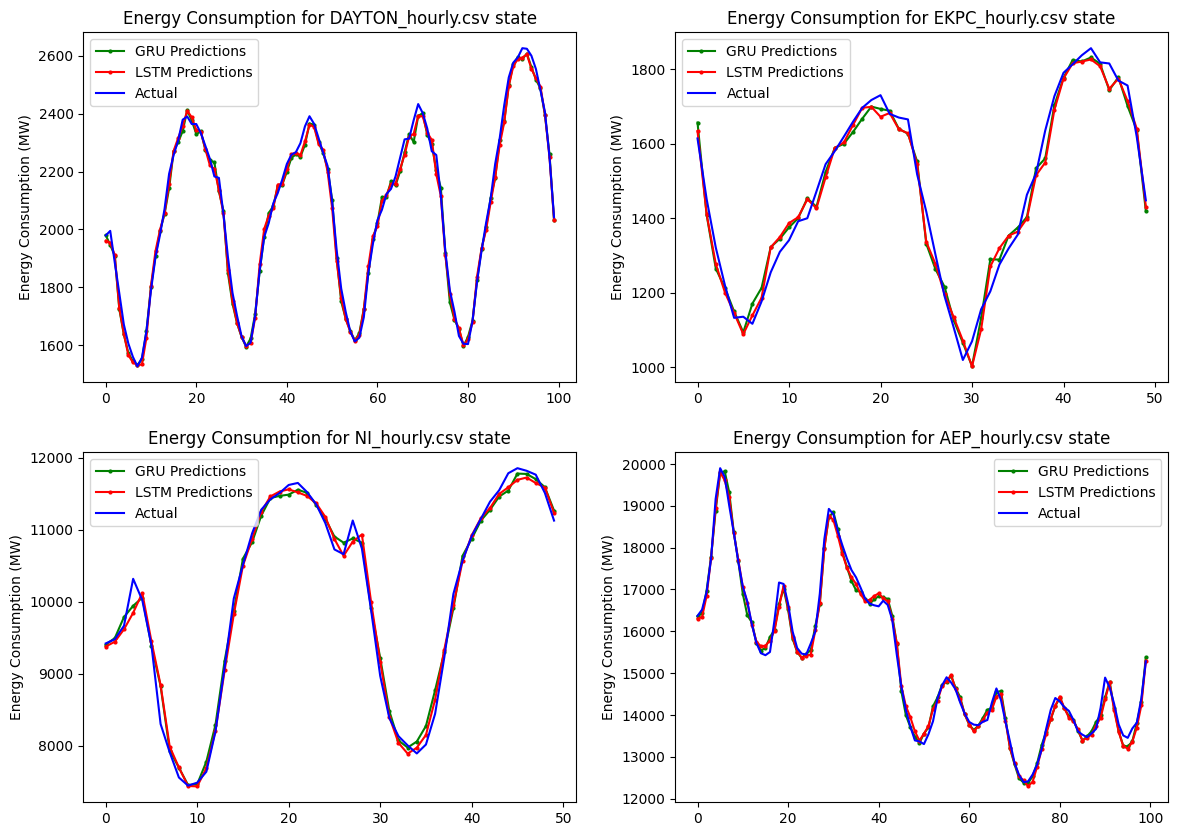

In [30]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(
    lstm_outputs[0][-100:], "-o", color="r", label="LSTM Predictions", markersize=2
)
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(gru_outputs[1][-50:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[1][-50:], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[1][-50:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[1]} state")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(gru_outputs[2][:50], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[2][:50], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[2][:50], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[2]} state")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(gru_outputs[3][:100], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[3][:100], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[3][:100], color="b", label="Actual")
plt.title(f"Energy Consumption for {states_list[3]} state")
plt.ylabel("Energy Consumption (MW)")
plt.legend()
plt.show()

Looks like the models are largely successful in predicting the trends of energy consumption. While they may still get some changes wrong, such as delays in predicting a drop in consumption, the predictions follow very closely to the actual line on the test set. This is due to the nature of energy consumption data and the fact that there are patterns and cyclical changes that the model can account for. Tougher time-series prediction problems such as stock price prediction or sales volume prediction may have data that is largely random or doesn’t have predictable patterns, and in such cases, the accuracy will definitely be lower.